This notebook plots the value and ROI of multiple different strategies

In [1]:
import numpy as np
import torch
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tabulate import tabulate

import Quant.Signals as qs
import Quant.Strategy as qstrat
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
TICKER = "AAPL"
startDate = "2021-01-01"
Volume = yf.download(TICKER, start=startDate)['Volume'][TICKER]
Close = yf.download(TICKER, start=startDate)['Close'][TICKER]
VIX = yf.download("^VIX", start=startDate)['Close']['^VIX']

C:\Users\adamd\AppData\Local\Temp\ipykernel_21828\2518625032.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Volume = yf.download(TICKER, start=startDate)['Volume'][TICKER]
[*********************100%***********************]  1 of 1 completed
C:\Users\adamd\AppData\Local\Temp\ipykernel_21828\2518625032.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Close = yf.download(TICKER, start=startDate)['Close'][TICKER]
[*********************100%***********************]  1 of 1 completed
C:\Users\adamd\AppData\Local\Temp\ipykernel_21828\2518625032.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VIX = yf.download("^VIX", start=startDate)['Close']['^VIX']
[*********************100%***********************]  1 of 1 completed


In [ ]:
#Signals
cross_10_50 = qs.moving_average(Close, window=10) - qs.moving_average(Close, window=50)
cross_10_50 = cross_10_50 / cross_10_50.std()
EWMA_10 = qs.EWMA(Close, window=10) / qs.stddev(Close, window=50)
EWMA_50 = qs.EWMA(Close, window=50) / qs.stddev(Close, window=50)
Vol_regime = qs.EWMA(Volume, window=10) / qs.EWMA(Volume, window=50) - 1.0
Vol_regime = Vol_regime / qs.stddev(Vol_regime, window=50)
std_50 = qs.stddev(Close, window=50)
Bollinger_Lower = (qs.Bollinger_Lower(Close, window=20, num_std=1) - Close) / qs.stddev(Close, window=20)
Bollinger_Upper = (qs.Bollinger_Upper(Close, window=20, num_std=1) - Close) / qs.stddev(Close, window=20)


# Baseline Strategies
BuyNHold = qstrat.buy_and_hold(Close)


Sharpes = { "Buy and Hold": BuyNHold[2]}
print(tabulate(Sharpes.items(), headers=["Strategy", "Sharpe Ratio"]))

X = pd.DataFrame({
    'EWMA_10': EWMA_10,
    'EWMA_50': EWMA_50,
    'Vol_regime': Vol_regime,
    'std_50': std_50,
    'VIX': VIX / VIX.std(),
    'Bollinger_Lower': Bollinger_Lower,
    'Bollinger_Upper': Bollinger_Upper
})
is_real = torch.tensor((1 - X.isna().any(axis=1)).astype(np.float32), device=device)
X = torch.tensor(X.fillna(0).values.astype(np.float32), dtype=torch.float32, device=device)
r = torch.tensor(np.log(Close / Close.shift(1)).fillna(0).values, dtype=torch.float32, device=device)
model = qstrat.LATW(torch.tensor(Close.values, dtype=torch.float32, device=device),
                    X, is_real, device=device).to(device)
model.load(f'{TICKER}_LATW_model.pth')
model.fit(lr=0.03, epochs=100)

model.save(f'{TICKER}_LATW_model.pth')


C:\Users\adamd\AppData\Local\Temp\ipykernel_21828\1783656172.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  is_real = torch.tensor((1 - X.isna().any(axis=1)).astype(np.float32), device=device)


Annualized return: 0.1891800042417986, std: 0.2725247800690101
Strategy        Sharpe Ratio
------------  --------------
Buy and Hold        0.694175


FileNotFoundError: [Errno 2] No such file or directory: 'AAPL_LATW_model.pth'

In [ ]:

with torch.no_grad():
    positions = model()  # trading signals in (-1, 1)


    # Logic 2
    strat_returns2 = positions[:-1] * r[1:]
    strat_returns2 = strat_returns2.cpu()
    strat_returns2 = torch.cat((torch.tensor([0.0]), strat_returns2))
    Total_Value2 = 10000 * torch.exp(torch.cumsum(strat_returns2, dim=0)).cpu().numpy()
    log_value_rets2 = torch.diff(torch.log(torch.tensor(Total_Value2)), prepend=torch.tensor([0.0]))
    annualized_return2 = log_value_rets2.mean() * 252
    annualized_vol2 = log_value_rets2.std() * (252 ** 0.5)
    print(f"Final annualized return (Logic 2): {annualized_return2.item():.4f}")
    print(f"Final annualized volatility (Logic 2): {annualized_vol2.item():.4f}")
    sharpe2 = annualized_return2 / annualized_vol2
    print(f"Final Sharpe ratio (Logic 2): {sharpe2.item():.4f}")

    # Robust Logic
    at = model.Zscore_strategy_atan()
    Value = at[0].cpu().numpy()
    Total_ret = Value[-1] / Value[0] - 1
    ann_ret = (1 + Total_ret) ** (252 / (len(Value)-1)) - 1
    ann_vol = np.log(Value[1:] / Value[:-1]).std() * (252 ** 0.5)
    print(f"Final annualized return (Robust Logic): {ann_ret:.4f}")
    print(f"Final annualized volatility (Robust Logic): {ann_vol:.4f}")
    print(f"Final Sharpe ratio (Robust Logic): {ann_ret / ann_vol:.4f}")

Final annualized return (Logic 2): 2.1620
Final annualized volatility (Logic 2): 4.1977
Final Sharpe ratio (Logic 2): 0.5150
Final annualized return (Robust Logic): 0.2789
Final annualized volatility (Robust Logic): 0.1262
Final Sharpe ratio (Robust Logic): 2.2095


C:\Projects\Quant\Quant\Strategy.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.76439338706344' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  shares.iloc[i] = shares.iloc[i - 1] + delta_shares


Annualized return: 0.15028016681863088, std: 0.17228458011932907
Final annualized return (Robust Logic): 0.1503
Final annualized volatility (Robust Logic): 0.1723
Final Sharpe ratio (Robust Logic): 0.8723


C:\Users\adamd\AppData\Local\Temp\ipykernel_24984\2157222102.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Total_ret = Value[-1] / Value[0] - 1


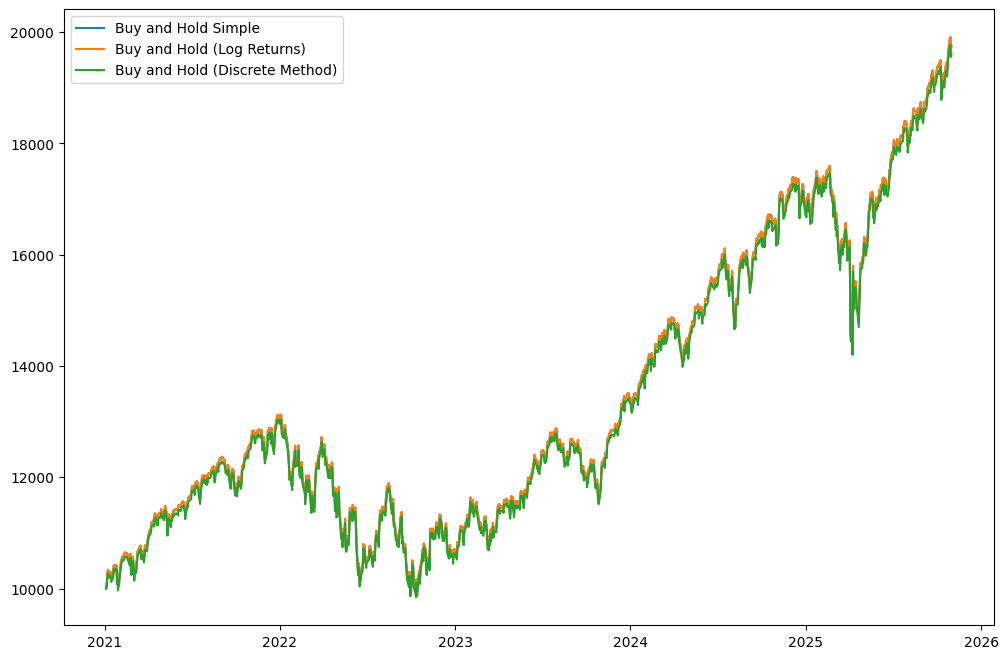

In [ ]:
# BuyNHold Verification

# Stupid Simple Buy and Hold
Shares = 10000 / Close.iloc[0]
Y1 = Shares * Close

# With Log Returns
log_ret = np.log(Close / Close.shift(1)).fillna(0)
Y2 = 10000 * np.exp(np.cumsum(log_ret))

# Discrete Method
Y3 = qstrat.Zscore_strategy_atan(Close, Close, w = 0, b = 1e10) # should be equivalent to Buy and Hold
Value = Y3[0]
Total_ret = Value[-1] / Value[0] - 1
ann_ret = (1 + Total_ret) ** (252 / (len(Value)-1)) - 1
ann_vol = np.log(Value / Value.shift(1)).dropna().std() * (252 ** 0.5)
print(f"Final annualized return (Robust Logic): {ann_ret:.4f}")
print(f"Final annualized volatility (Robust Logic): {ann_vol:.4f}")
print(f"Final Sharpe ratio (Robust Logic): {ann_ret / ann_vol:.4f}")



plt.figure(figsize=(12, 8))
plt.plot(Y1, label='Buy and Hold Simple')
plt.plot(Y2, label='Buy and Hold (Log Returns)')
plt.plot(Y3[0], label='Buy and Hold (Discrete Method)')
plt.legend()
plt.show()


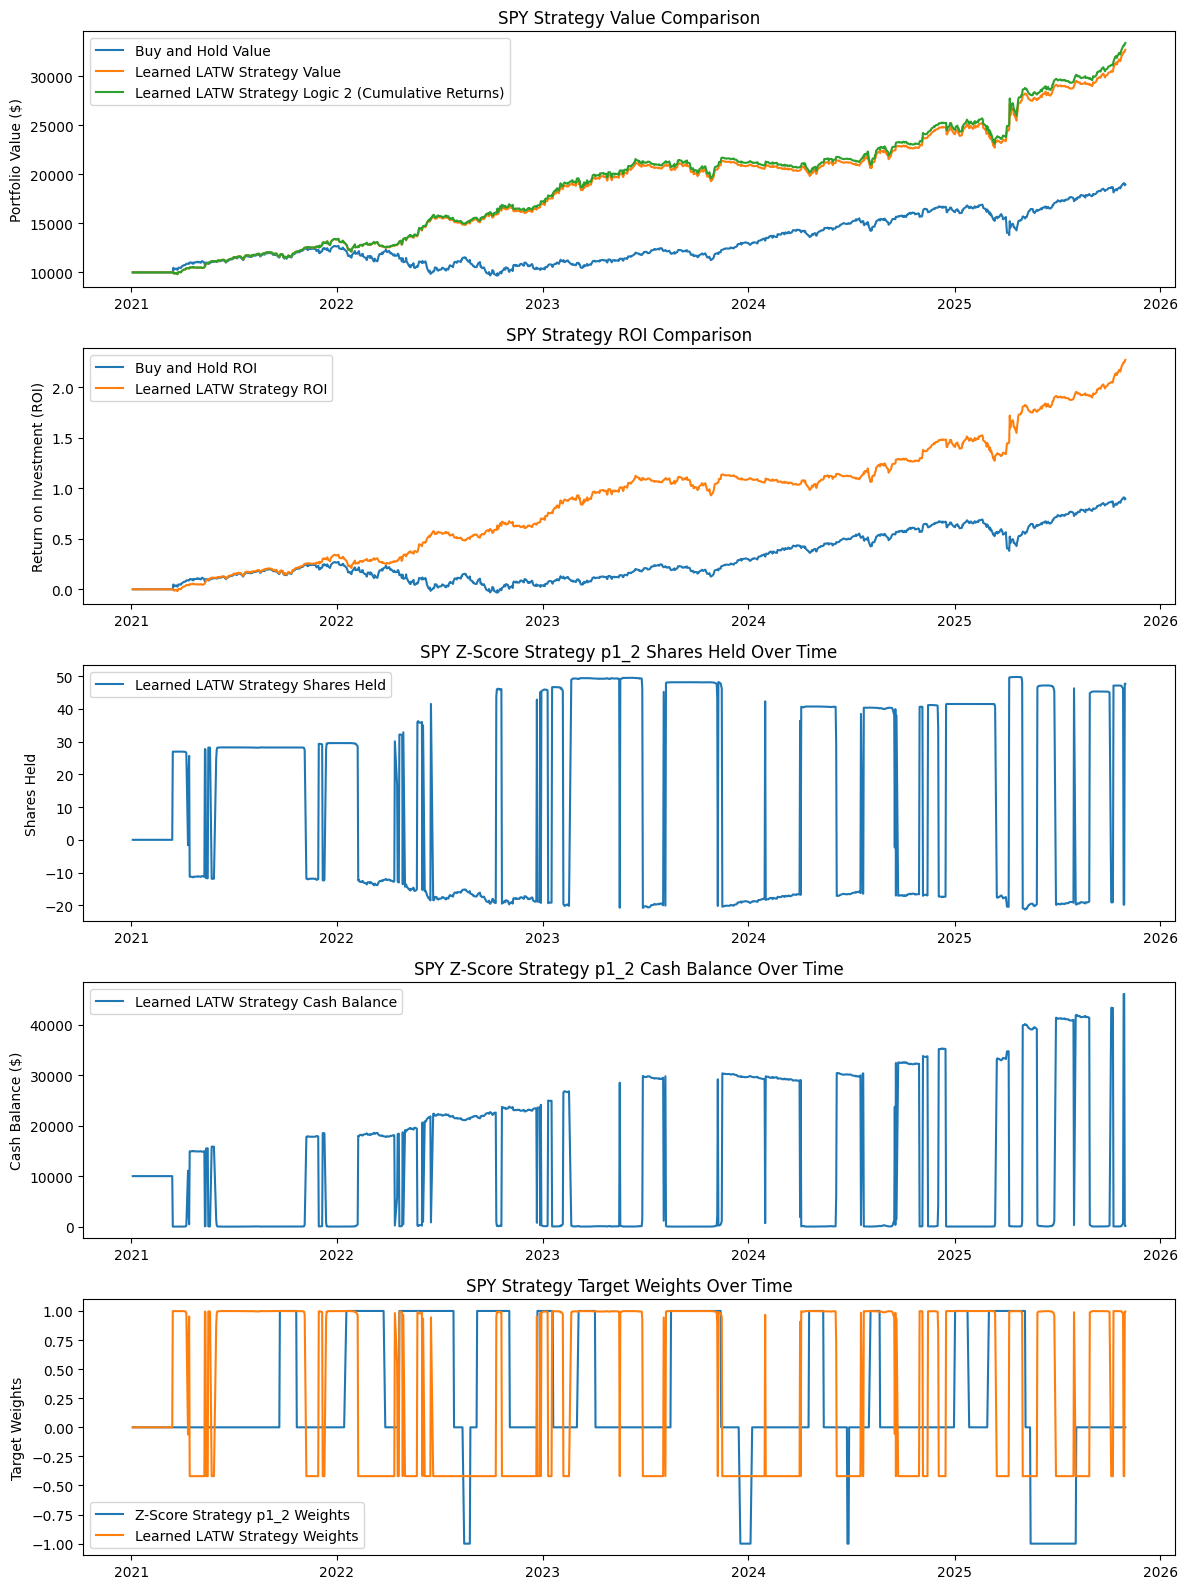

In [ ]:

fig, ax = plt.subplots(5, 1, figsize=(12, 16))
dollarPlot = ax[0]
roiPlot = ax[1]
sharesPlot = ax[2]
bankPlot = ax[3]
weightsPlot = ax[4]

dollarPlot.plot(Close.index, BuyNHold[0], label='Buy and Hold Value')
# dollarPlot.plot(Close.index, Cross[0], label='Crossover 10/50 Value')
# dollarPlot.plot(Close.index, CrossZscore_1_1[0], label='Z-Score Strategy Value')
# dollarPlot.plot(Close.index, CrossZScore_p1_2[0], label='Z-Score Strategy p1_2 Value')
# dollarPlot.plot(Close.index, CrossZScore_3[0], label='Z-Score Strategy 3 Value')
# dollarPlot.plot(Close.index, LATW_1[0], label='Z-Score Strategy Atan Value')
dollarPlot.plot(Close.index, at[0].cpu(), label='Learned LATW Strategy Value')
dollarPlot.plot(Close.index, Total_Value2, label='Learned LATW Strategy Logic 2 (Cumulative Returns)')

roiPlot.plot(Close.index, BuyNHold[1], label='Buy and Hold ROI')
# roiPlot.plot(Close.index, Cross[1], label='Crossover 10/50 ROI')
# roiPlot.plot(Close.index, CrossZscore_1_1[1], label='Z-Score Strategy ROI')
# roiPlot.plot(Close.index, CrossZScore_p1_2[1], label='Z-Score Strategy p1_2 ROI')
# roiPlot.plot(Close.index, CrossZScore_3[1], label='Z-Score Strategy 3 ROI')
# roiPlot.plot(Close.index, LATW_1[1], label='Z-Score Strategy Atan ROI')
roiPlot.plot(Close.index, at[1].cpu(), label='Learned LATW Strategy ROI')


sharesPlot.plot(Close.index, at[3].cpu(), label='Learned LATW Strategy Shares Held')


bankPlot.plot(Close.index, at[4].cpu(), label='Learned LATW Strategy Cash Balance')

weightsPlot.plot(( (cross_10_50<.1).astype(int) - (cross_10_50>1.5).astype(int) ), label='Z-Score Strategy p1_2 Weights')
weightsPlot.plot(Close.index, at[5].cpu(), label='Learned LATW Strategy Weights')

dollarPlot.set_title(f'{TICKER} Strategy Value Comparison')
dollarPlot.set_ylabel('Portfolio Value ($)')
dollarPlot.legend(loc='upper left')

roiPlot.set_ylabel('Return on Investment (ROI)')
roiPlot.set_title(f'{TICKER} Strategy ROI Comparison')
roiPlot.legend(loc='upper left')

sharesPlot.set_ylabel('Shares Held')
sharesPlot.set_title(f'{TICKER} Z-Score Strategy p1_2 Shares Held Over Time')
sharesPlot.legend()

bankPlot.set_ylabel('Cash Balance ($)')
bankPlot.set_title(f'{TICKER} Z-Score Strategy p1_2 Cash Balance Over Time')
bankPlot.legend()

weightsPlot.set_ylabel('Target Weights')
weightsPlot.set_title(f'{TICKER} Strategy Target Weights Over Time')
weightsPlot.legend()

plt.tight_layout()
plt.show()